In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

import warnings
warnings.filterwarnings("ignore")

# seaborn default set işlemi
sns.set()

# notebook için 'png' set işlemi
%config InlineBackend.figure_format = 'png' #grafikleri png formatında göreceğiz
%matplotlib inline

# data setlerin yolları
trainData = 'data/house_train.csv'
testData = 'data/house_test.csv'

# data setleri import edelim
train = pd.read_csv(trainData, header=0)
test = pd.read_csv(testData, header=0)

In [2]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [4]:
# bütün datayı birleştirelim (Id ve SalePrice sütunlarını almadan)
#loc burada etiketleme yapar, yani şu satırdaki şu sutnu getir demek 
#MSSubClass' sütunundan başlayarak 'SaleCondition' sütununa kadar olan sütunları seçiyoruz. : işareti, tüm satırları seçtiğimizi belirtir.
all_data= pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], 
                     test.loc[:,'MSSubClass':'SaleCondition']))
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


**Veri Önişleme (Data Preprocessing)**

Basit olarak aşağıdaki ön işleme adımlarını yapacağız:
1. Outlier'ları atacağız (net olanları, gerçek verini çok dışında kalanlar, aykırı değer)
2. string olması gereken numerik sütunları, string yapacağız (years, months vb.)
3. kategorik olanları encode edeceğiz (LabelEncoder ve OneHotEncoder)
4. Normalizasyon
5. eksik verileri yöneteceğiz
6. regresyon için matris formları düzenleyeceğiz

**Outliers**

Outlier demek verinin kümelendiği yerin çok dışında kalan veri noktaları demek. Outlier silmek her zaman tehlikeli bir iştir. Kıymetli verinizi kaybedebilirsiniz çünkü. Ama bazen zorunludur, aksi halde modelinizi yanlış yönlendirme riski vardır.

**68-95-99 Kuralı**

https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule

Datanın:
* %68'i 1 standart sapma genişliğinde bulunur
* %95'i 2 standart sapma genişliğinde bulunur
* %99'u 3 standart sapma genişliğinde bulunur

Dolayısı ile 3 standart sapma genişliğini hesaplayıp, onun dışında kalanlara `Outlier` diyebiliriz.

In [5]:
"""burada mean değeri ortalamayı kast etmektedir. Ve stdye bakılır 
Ortalamanın 3 standart sapma sağı ve solu: -60,98 <....> 3091.9 bu
aralığın dışında ise outlier olur."""
train["GrLivArea"].describe()

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

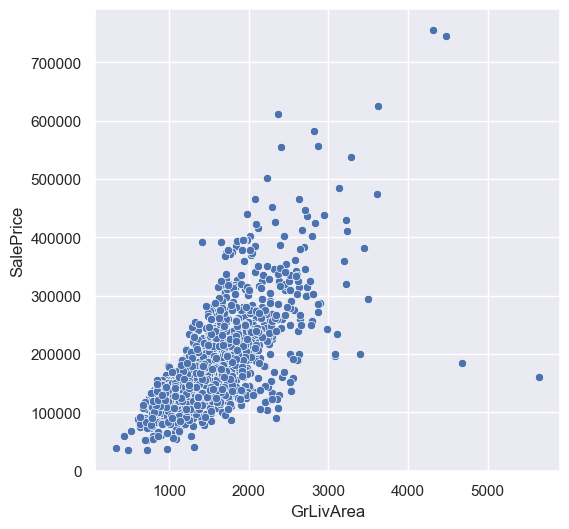

In [6]:
"""rcParams: Matplotlib'in grafiklerin görünümünü ayarlamak için kullanılan 
parametrelerin bir koleksiyonudur. ["figure.figsize"]= (6.0, 6.0): Bu, grafiklerin varsayılan genişlik ve yüksekliğini
ayarlar. (6.0, 6.0) değeri, grafiklerin genişliğinin ve yüksekliğinin 
sırasıyla 6 birim olmasını belirtir. """

# figure'un şekli
rcParams["figure.figsize"]= (6.0, 6.0)

#seaborn ile görselleştirme
sns.scatterplot(x="GrLivArea", y="SalePrice", data=train)
plt.show()

In [7]:
# outlier atmadan önce şekil
train.shape

(1460, 81)

In [8]:
# şimdi outlier'ları atalım
train = train.drop(train[train["GrLivArea"]>3200].index).reset_index(drop=True)

In [9]:
# outlier attıktan sonra şekil
train.shape

(1447, 81)

In [10]:
# outlier atılmış hali ile test datayı tekrar birleştirelim
"""MSSubClass' sütunundan başlayarak 'SaleCondition' sütununa kadar olan sütunları seçiyoruz. : işareti, 
tüm satırları seçtiğimizi belirtir. """
all_data= pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition'] ))

In [11]:
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


**Numerik'leri String Yapma (normalde String olması gerekenler için)**

In [12]:
all_data.YrSold

0       2008
1       2007
2       2008
3       2006
4       2008
        ... 
1454    2006
1455    2006
1456    2006
1457    2006
1458    2006
Name: YrSold, Length: 2906, dtype: int64

In [13]:
# tür dönüşümü yapalım
"""Burada birincisinde apply fonksiyonunun kullanılmasıyla her bir değere ayrı
ayrı bir işlem uygulanmasıdır, ikincisinde ise astype fonksiyonuyla sütundaki 
tüm değerlerin aynı veri tipine dönüştürülmesidir. """

all_data["MSSubClass"]= all_data["MSSubClass"].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

**Kategorik Sütunları Encode Etme**

In [14]:
from sklearn.preprocessing import LabelEncoder

In [15]:
#encode edilecek sütunlar
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

In [16]:
# döngü ile bütün sütunları encode et
""""LabelEncoder sınıfı, verileri liste olarak bekler. Bu nedenle, veri
yapısını listeye dönüştürmek bu tür durumlarda gerekli olabilir."""
for c in cols:
    lbl= LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c]= lbl.transform(list(all_data[c].values))

In [17]:
# bütun sütunları görelim
all_data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [18]:
# OneHotEncoder öncesi datanın şekli
all_data.shape

(2906, 79)

In [19]:
# şimdi one hot encoder yapabiliriz -> get_dummies()
all_data= pd.get_dummies(all_data)

In [20]:
all_data.shape

(2906, 218)

In [21]:
# yeni sütunları görelim

all_data.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=218)

In [22]:
all_data.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,10,65.0,8450,1,2,3,0,7,4,2003,...,False,False,False,True,False,False,False,False,True,False
1,5,80.0,9600,1,2,3,0,6,7,1976,...,False,False,False,True,False,False,False,False,True,False
2,10,68.0,11250,1,2,0,0,7,4,2001,...,False,False,False,True,False,False,False,False,True,False
3,11,60.0,9550,1,2,0,0,7,4,1915,...,False,False,False,True,True,False,False,False,False,False
4,10,84.0,14260,1,2,0,0,8,4,2000,...,False,False,False,True,False,False,False,False,True,False


**Normilazyon**

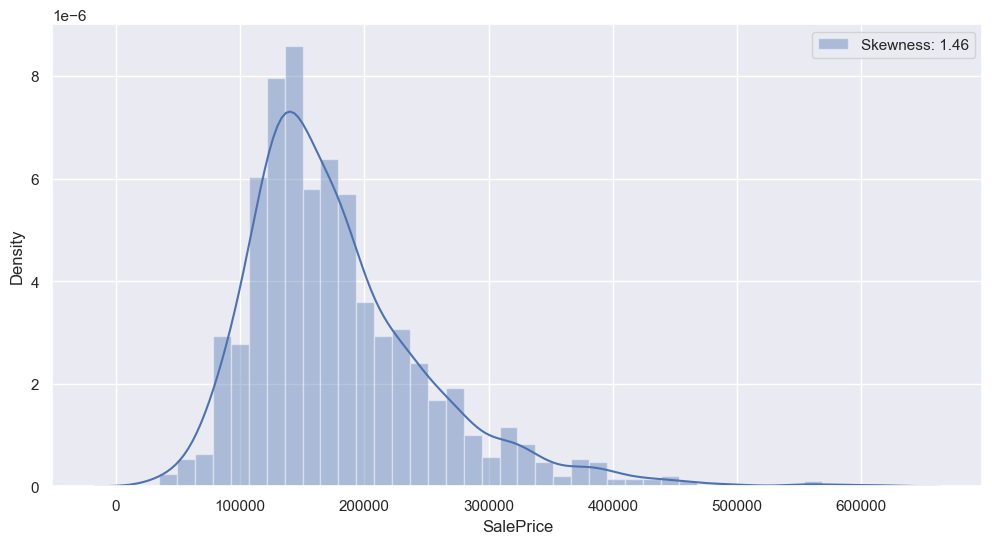

In [25]:
# scipy'in skew fonksiyonu bize skew yani kuyruk değerini verir
"""skew fonksiyonu, bir veri kümesinin eğrisel simetrisini (asimetrisini) 
ölçen istatistiksel bir metriktir. Asimetri, bir veri setinin sağa veya sola 
doğru ne kadar eğildiğini gösterir."""

from scipy.stats import skew

# "SalePrice" için histogram
rcParams["figure.figsize"]=(12.0, 6.0) #rcParams: Matplotlib'in özelleştirilebilir ayarlarını tutan bir yapıdır.

g = sns.distplot(train["SalePrice"], label="Skewness: %.2f"%(train["SalePrice"].skew()))
#"%.2f" ifadesi, ondalık kısmın sadece iki basamağı görüntülemesini belirtir.
#burdaki ikinci % işareti format belirteci yerine geçer. 
g= g.legend(loc="best")
plt.show()

Burada görüldüğü üzre sağ tarafa doğru kuyruk oluşmuş. Biz grafiklerin simetrik olmasını isteriz ama böyle bir grafik doğru sonuçlar vermez. Log Transform yaparak datayı *normalize* edeceğiz. Sola kuyruk yapan datalarda bu çalışmaz.

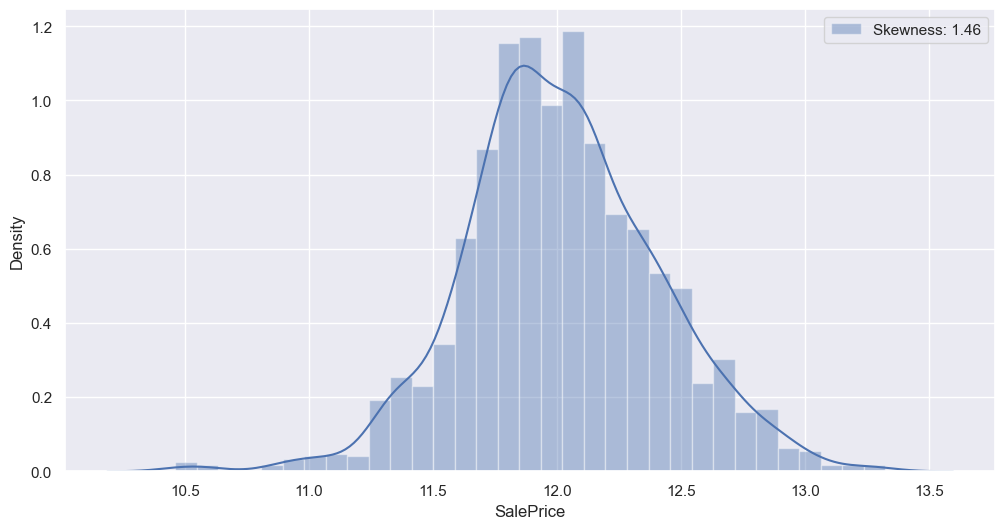

In [26]:
#burada dizinin her bir elemanının doğal logaritmasını alır ve sağa çarpıklığı bununla önler.
#log1p() fonksiyonu, log(1+x) işlemini yapar. Burada, x train["SalePrice"] dizisindeki her bir elemandır.
normalizedSalePrice= np.log1p(train["SalePrice"])

# "SalePrice" için histogram
rcParams["figure.figsize"]= (12.0, 6.0)

g = sns.distplot(normalizedSalePrice, label="Skewness: %.2f"%(train["SalePrice"].skew()))

g=g.legend(loc="best")
plt.show()

In [27]:
#datamız artık simetrik oldu, şimdi çıktıyı logaritmik haline eşitledik
train["SalePrice"] = np.log1p(train["SalePrice"])

**Eksik Verileri Yönetme**

In [34]:
# eksik veri var mı
"""Bu metot ikinci kez kullanılıyor, çünkü ilk .any() metodu sonucunda, 
her sütun için bir boolean değer döner. İkinci .any() metodu ise bu sütunlardaki
boolean değerlerin herhangi birinin True olup olmadığını kontrol eder. """
all_data.isnull().any().any() #bunun cevabı ilk başta True idi. 

False

In [35]:
# NA olan değerleri mean ile dolduralım, yani eksik dataları var olanların ortuyla dolduracak.
all_data= all_data.fillna(all_data.mean())

In [36]:
#şimdi bi daha soralım
all_data.isnull().any().any()

False

**Model Matrisleri**

In [37]:
# sklearn için matrisleri yaratlım
# burada traine kdr olan satırlara X_train ondan sonrakilere ise X_test dedik.
#slice=dilimleme
X_train = all_data[:train.shape[0]]#başlangıç

X_test = all_data[train.shape[0]:]#bitiş

y = train.SalePrice

In [38]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,10,65.0,8450,1,2,3,0,7,4,2003,...,False,False,False,True,False,False,False,False,True,False
1,5,80.0,9600,1,2,3,0,6,7,1976,...,False,False,False,True,False,False,False,False,True,False
2,10,68.0,11250,1,2,0,0,7,4,2001,...,False,False,False,True,False,False,False,False,True,False
3,11,60.0,9550,1,2,0,0,7,4,1915,...,False,False,False,True,True,False,False,False,False,False
4,10,84.0,14260,1,2,0,0,8,4,2000,...,False,False,False,True,False,False,False,False,True,False


In [39]:
X_train.shape

(1447, 218)

**Lineer Regresyon**

In [40]:
from sklearn.model_selection import cross_val_score

In [41]:
# k-fold cross validation kullanarak RMSE hesapla

def rmse_cv(model, cv=5):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv=cv))
    return rmse

In [43]:
from sklearn.linear_model import LinearRegression

linear_model= LinearRegression()

rmse= rmse_cv(linear_model)

print("RMSE Ortalaması: {}, std: {}".format(rmse.mean(),rmse.std()))

RMSE Ortalaması: 0.1259387126981571, std: 0.012154916840732255


In [44]:
# fit linear model
linear_model.fit(X_train, y)

LinearRegression()

In [46]:
# katsayılar, Toplamda 219 adet katsayı olması lazım (219 değişken var çünkü).
weights= linear_model.coef_
print(weights)

[ 1.45102751e-04  5.43931601e-04  1.96764825e-06  7.89658099e-02
 -8.95654512e-03  1.67900567e-03  2.27155238e-04  4.24102328e-02
  3.87245380e-02  1.90816516e-03  6.94259158e-04  1.95458044e-05
 -2.55909461e-03  1.02149127e-02 -1.05766167e-02  6.86221794e-03
 -3.97297440e-03 -9.31396205e-04  6.74292611e-05  2.24704482e-03
  2.91235913e-05 -8.10265401e-06  8.84501543e-05 -7.25072814e-03
  6.25465776e-02  8.21775438e-05  5.57126513e-05  4.84203010e-05
  1.86310354e-04  2.80919718e-02  1.08938362e-02  2.06433341e-02
  1.76128192e-02 -4.04598989e-03 -4.76338037e-02 -1.34887338e-02
  6.30762216e-03  1.80951014e-02  1.46670706e-02 -2.71944033e-03
 -1.44917445e-04 -3.02040469e-03  2.29900210e-02  9.25186193e-05
  4.92244545e-03  3.54023206e-03  1.11088338e-02  1.02575350e-04
  1.00242959e-04  1.32157914e-04  1.57766783e-04  2.75642080e-04
  6.25541103e-04  1.61294237e-01  3.98082985e-03 -7.67658473e-06
  4.59608159e-04 -2.65350224e-03 -3.18324201e-01  1.04587449e-01
  8.50398016e-02  8.23297

In [47]:
weights.shape

(218,)

In [48]:
# en büyük değerli katsayıları alalım (mutlak değer)
coef= pd.Series(weights, index=X_train.columns)

# ilk 10 (+) ve son 10 (-) büyük katsayıyı alalım (important coefficients)
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

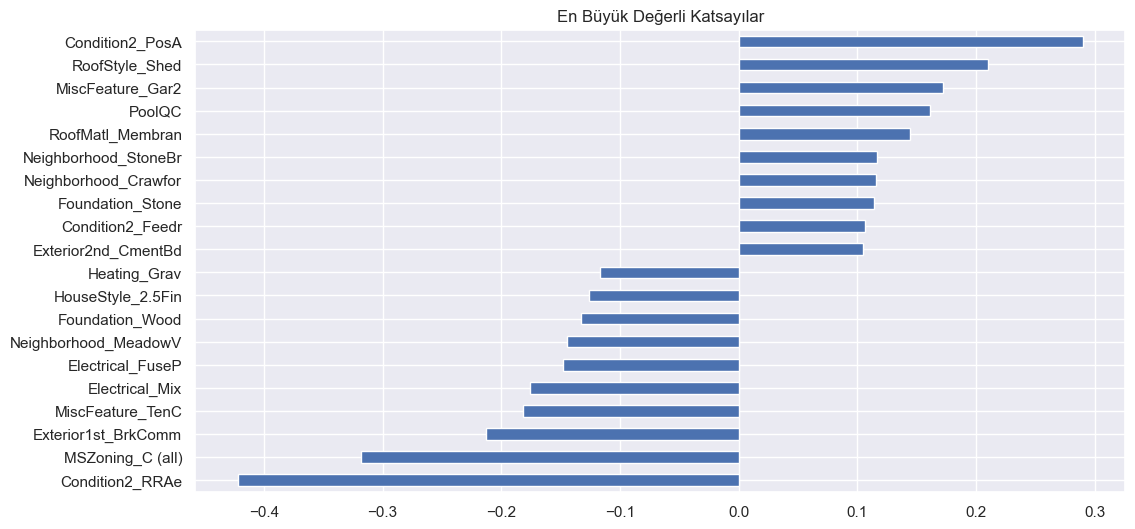

In [49]:
# şimdi bu katsayıları görelim, barh= yatay çubuk grafik

imp_coef.plot(kind="barh")
plt.title("En Büyük Değerli Katsayılar")
plt.show()

Burda katsayılar çok büyük 0.3lerde buda demek oluyorki 218 adet girdinin sadece 1 tanesi bile %30 etkiye sahip bunun nedeni yüksek katsayılara sahip olması şimdi bunu azaltmak için *Ridge Regression* yapacağız

**Ridge Regression (L2-Regularization)**

In [50]:
from sklearn.linear_model import Ridge

In [51]:
# alpha = 0.1 ile ridge regression modeli çalıştırıp RMSE hesaplayalım
ridgeModel= Ridge(alpha=0.1)

#cross validation ile RMSE alalım
rnse= rmse_cv(ridgeModel)#burada cv parametresi de var ama default 5 seçiyor zaten yazmaya gerek yok

print("RMSE Ortalaması: {}, std: {}".format(rmse.mean(), rmse.std()))

RMSE Ortalaması: 0.1259387126981571, std: 0.012154916840732255


In [52]:
# fit linear model
ridgeModel.fit(X_train, y)

Ridge(alpha=0.1)

In [53]:
# en büyük değerli katsayıları alalım (mutlak değer)
coef_ridge= pd.Series(ridgeModel.coef_, index=X_train.columns)

# ilk 10 ve son 10 büyük katsayıyı alalım (important coefficients)
imp_coef_ridge = pd.concat([coef_ridge.sort_values().head(10), coef_ridge.sort_values().tail(10)])

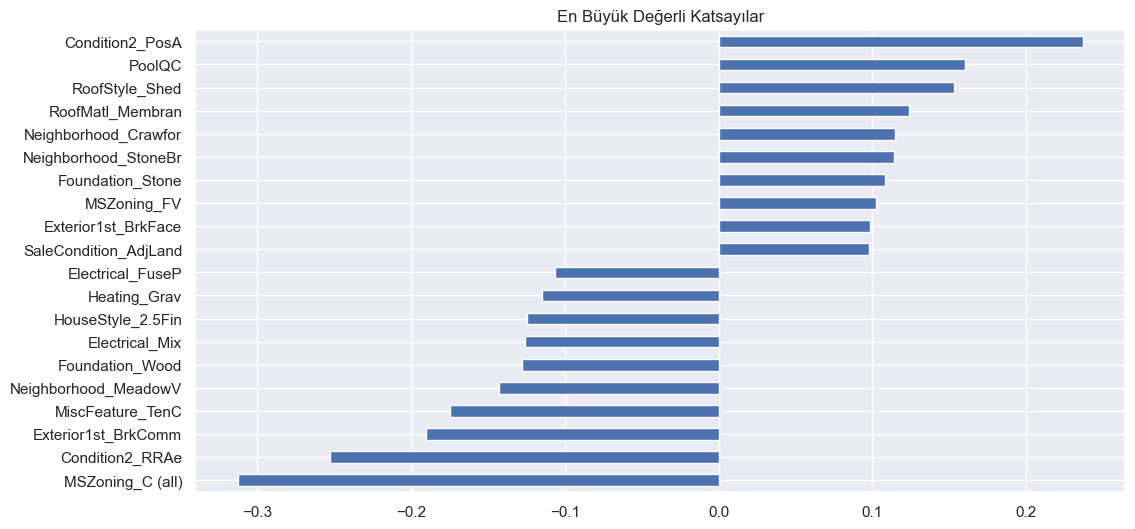

In [56]:
#şimdi bu katsayıları görelim

imp_coef_ridge.plot(kind="barh")
plt.title("En Büyük Değerli Katsayılar")
plt.show()

Bİr miktar azalmış olsada katsayılarımız hala çok büyük o yüzden şimdi $\alpha$ değerini değiştireceğiz. O yüzde Hyperparameter Tuning yapıyoruz.

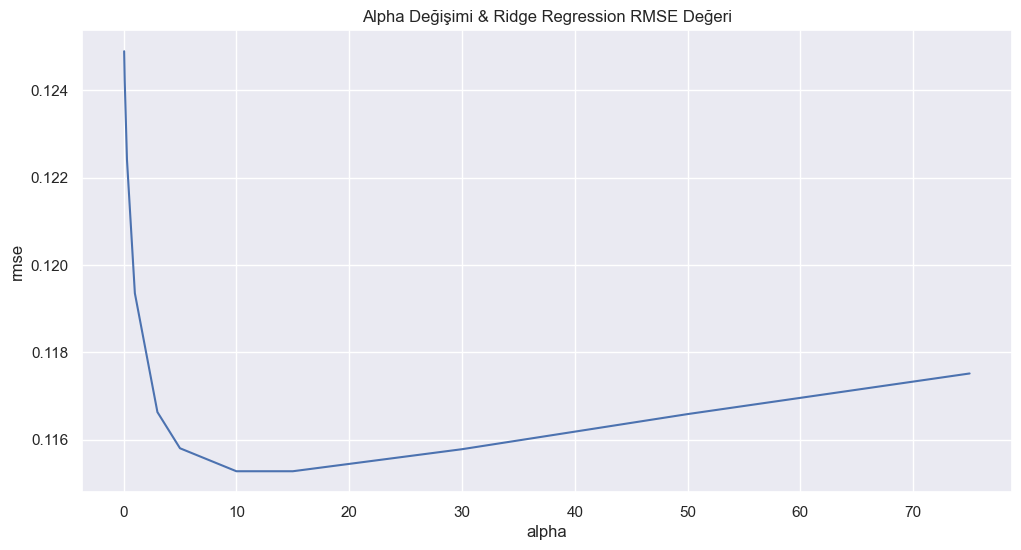

In [59]:
# farklı alpha değerleri için RMSE hesapla
alphas=[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]

#cv_ridge adlı bir liste oluşturulur. Bu liste, farklı alpha değerlerine karşılık gelen Ridge regresyon modelinin çapraz doğrulama ile hesaplanan RMSE değerlerini içerir. 
cv_ridge= [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

#burada cv_ridge listesi bir pandas serisine dönüştürülür ve içine alphlar konur.
cv_ridge = pd.Series(cv_ridge, index = alphas)

# RMSE vs alpha grafiği
cv_ridge.plot(title = "Alpha Değişimi & Ridge Regression RMSE Değeri")

plt.xlabel("alpha")
plt.ylabel("rmse")

plt.show()

In [63]:
#garfiğe göre a değeri 10 olarak gözüküyor tam olarak bakalım

optimalRidgeAlpha = cv_ridge[cv_ridge == cv_ridge.min()].index.values[0]

print("Optimal Ridge Alpha Değeri: {}".format(optimalRidgeAlpha))
#ama bende 15 çıktı

Optimal Ridge Alpha Değeri: 15.0


In [64]:
# optimal alpha ile ridge regression modelin RMSE değerini bulalım
ridgeModel= Ridge(alpha= optimalRidgeAlpha)
rmse= rmse_cv(ridgeModel)
print("RMSE Ortalamsı: {}, std: {}".format(rmse.mean(),rmse.std()))

RMSE Ortalamsı: 0.1152751390736669, std: 0.00703016948514615


In [65]:
ridgeModel.fit(X_train,y)

Ridge(alpha=15.0)

In [66]:
# en büyük değerli katsayıları alalım (mutlak değer)
coef_ridge= pd.Series(ridgeModel.coef_, index= X_train.columns)

# ilk 10 ve son 10 büyük katsayıyı alalım (important coefficients)
imp_coef_ridge= pd.concat([coef_ridge.sort_values().head(10), coef_ridge.sort_values().tail(10)])

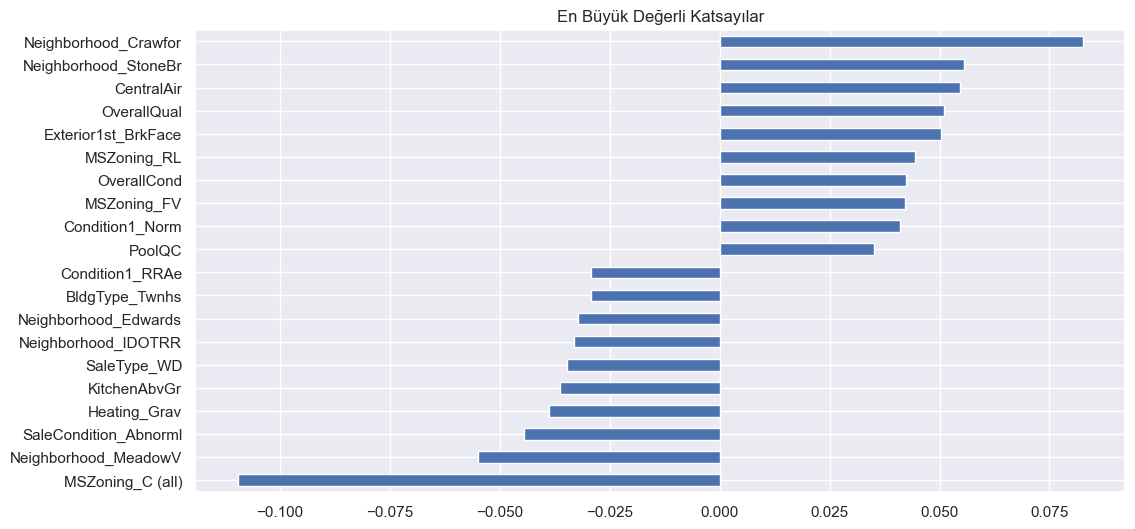

In [67]:
imp_coef_ridge.plot(kind="barh")
plt.title("En Büyük Değerli Katsayılar")
plt.show()

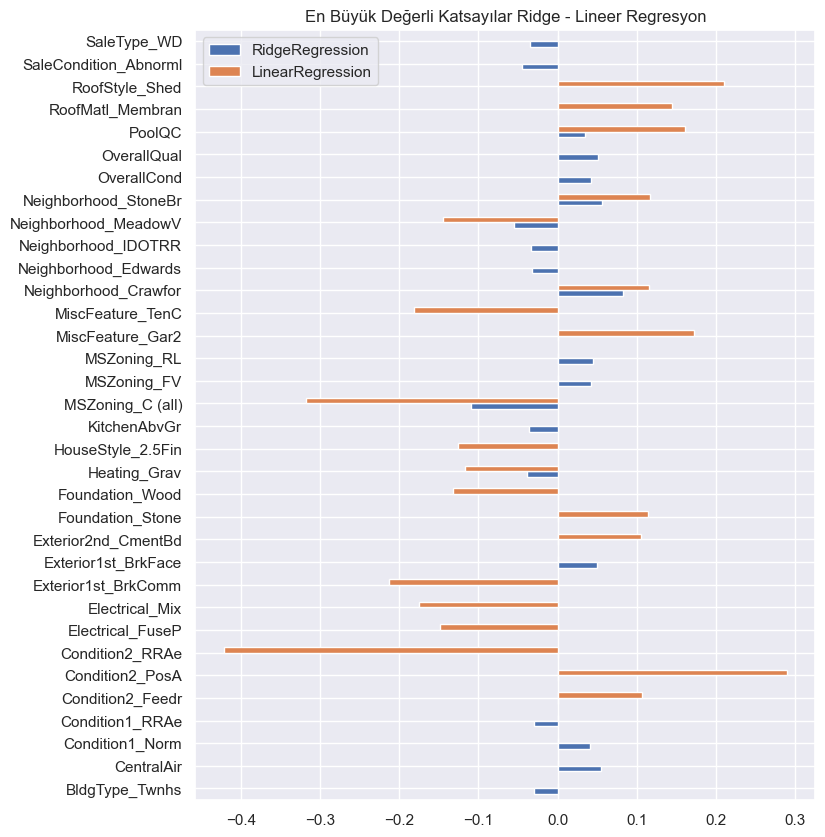

In [68]:
# en büyük değerli katsayılar
ridge_coef=pd.Series(ridgeModel.coef_, index= X_train.columns)
ridge_imp_coef= pd.concat([ridge_coef.sort_values().head(10), ridge_coef.sort_values().tail(10)])
rcParams["figure.figsize"]=[8.0,10.0]

df= pd.DataFrame({"RidgeRegression": ridge_imp_coef, "LinearRegression": imp_coef})

df.plot(kind = "barh")
plt.title("En Büyük Değerli Katsayılar Ridge - Lineer Regresyon")

plt.show()

**Lasso Regression (L1-Regularization)**

In [69]:
from sklearn.linear_model import Lasso

In [70]:
# determine RMSE for lasso regression model with alpha = 0.1
lassoModel = Lasso(alpha = 0.1)
rmse = rmse_cv(lassoModel)
print("RMSE Ortalaması: {}, std: {}".format(rmse.mean(), rmse.std()))

RMSE Ortalaması: 0.16050445222133874, std: 0.004752739580228101


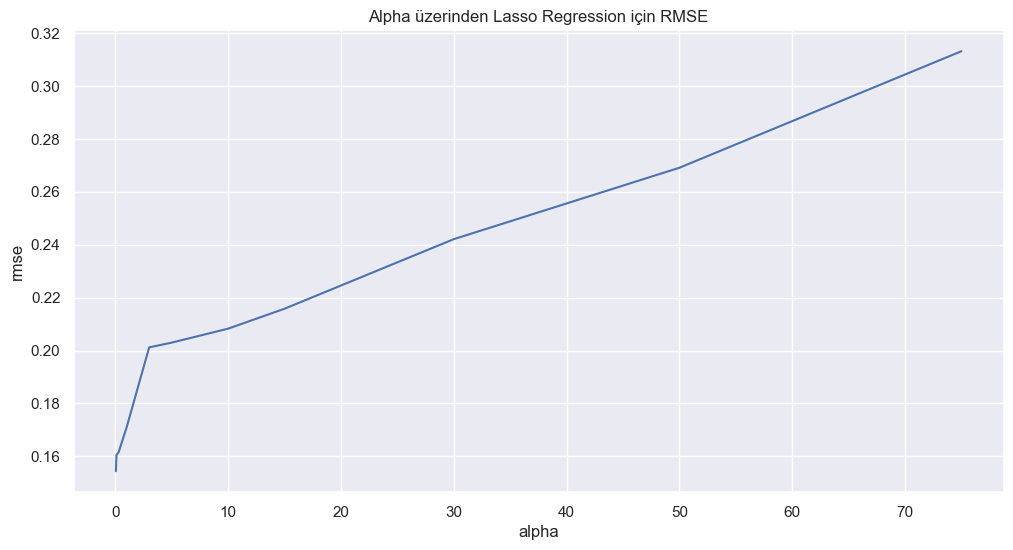

In [71]:
# Farklı alpha değerleri için RMSE hesapla

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]

cv_lasso = [rmse_cv(Lasso(alpha = alpha)).mean() for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index = alphas)

# grafiğin boyutu
rcParams['figure.figsize'] = (12.0, 6.0)

# plot RMSE vs alpha
cv_lasso.plot(title = "Alpha üzerinden Lasso Regression için RMSE")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

Burada alphanın düşmesi gerekn yerde sürekli arttığını görüyoruz. Bu da yanlış alpha değerini kullandığımızı gösteriyor. Biz bunun için belli bir alpha aralığı verip onun arasından seçmiştik ama bu alpha o aralıkta değil. En uygun alphayı Hyperparameter Tuning ile bulacağız bunu yapan modelimiz ise LassoCVdir. 

In [72]:
from sklearn.linear_model import LassoCV

# LassoCV ile en uygun alpha değerini bul
lassoModel = LassoCV(alphas = np.linspace(0.0002, 0.0022, 21), cv = 5).fit(X_train, y)
lassoModel.alpha_

optimalLassoAlpha = lassoModel.alpha_
print("Optimal lasso alpha: {}".format(optimalLassoAlpha))

Optimal lasso alpha: 0.0005


In [73]:
#En uygun alphanın 0.0005 olduğunu gördük
lassoModel = Lasso(alpha = optimalLassoAlpha)

rmse = rmse_cv(lassoModel)

print("RMSE Ortalaması: {}, std: {}".format(rmse.mean(), rmse.std()))

RMSE Ortalaması: 0.11299035003780697, std: 0.007182660814070063


Hatta şu anda en iyi RMSE, Lasso'da diyebiliriz:
* Linner Regresyon: RMSE = 0.1259
* Ridge: RMSE = 0.1152
* Lasso: RMSE = 0.1129

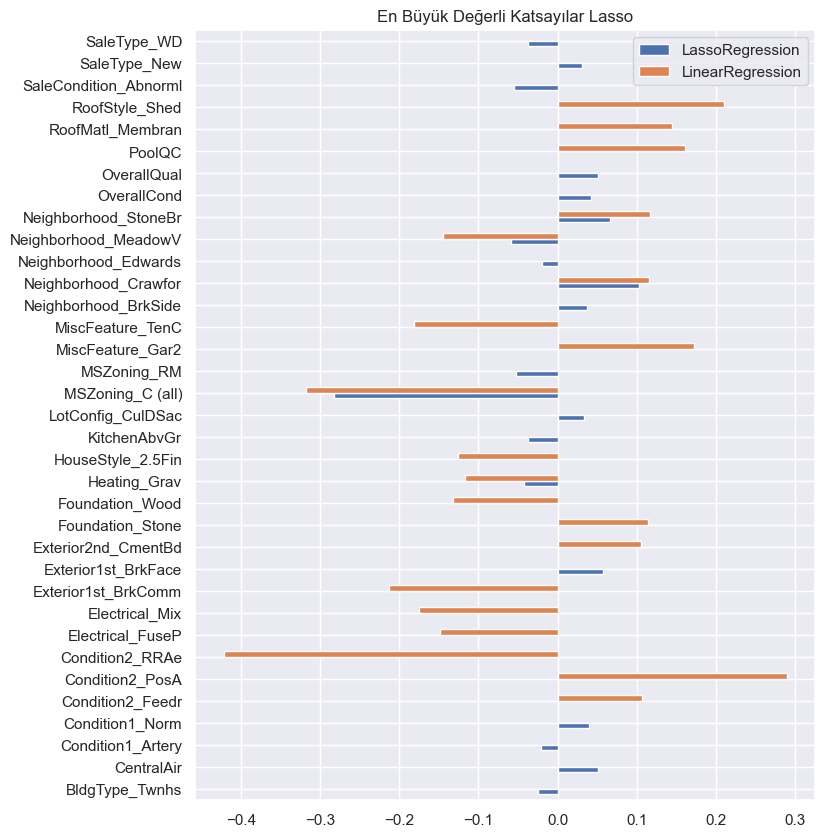

In [74]:
# fit lasso model
lassoModel.fit(X_train, y)

# en büyük değerli katsayılar
lasso_coef = pd.Series(lassoModel.coef_, index = X_train.columns)
lasso_imp_coef = pd.concat([lasso_coef.sort_values().head(10), lasso_coef.sort_values().tail(10)])

rcParams['figure.figsize'] = (8.0, 10.0)

df = pd.DataFrame({ "LassoRegression" : lasso_imp_coef, "LinearRegression" : imp_coef })

df.plot(kind = "barh")
plt.title("En Büyük Değerli Katsayılar Lasso")
plt.show()

Lasso gereksiz gördüğü Xlerin katsayısını 0 yaptı buna Feature Elimination (Değişken Azaltma) denir.


**Ridge ve Lasso Farkı**

* Ridge, yüksek katsayı değerlerini cezalandırır ama onları sıfır yapmaya zorlamaz
* Lasso ise olabildiğince fazla katsayıyı sıfır yapmaya zorlar

In [75]:
ridge_coef = pd.Series(ridgeModel.coef_, index = X_train.columns)
print('Sıfır Olmayan Katsayı Adedi - Ridge:', sum(ridge_coef != 0))
print('Sıfır Katsayı Adedi - Ridge:', sum(ridge_coef == 0))

Sıfır Olmayan Katsayı Adedi - Ridge: 218
Sıfır Katsayı Adedi - Ridge: 0


In [76]:
lasso_coef = pd.Series(lassoModel.coef_, index = X_train.columns)
print('Sıfır Olmayan Katsayı Adedi - Lasso:', sum(lasso_coef != 0))
print('Sıfır Katsayı Adedi - Lasso:', sum(lasso_coef == 0))

Sıfır Olmayan Katsayı Adedi - Lasso: 96
Sıfır Katsayı Adedi - Lasso: 122
